<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/Insurance4paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=034fbb34d2465f560d75de4bbacd0b563ded88c23a7b1dcf2b5367b8f2c5607c
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Step 1: Load Data and Perform EDA



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.dri

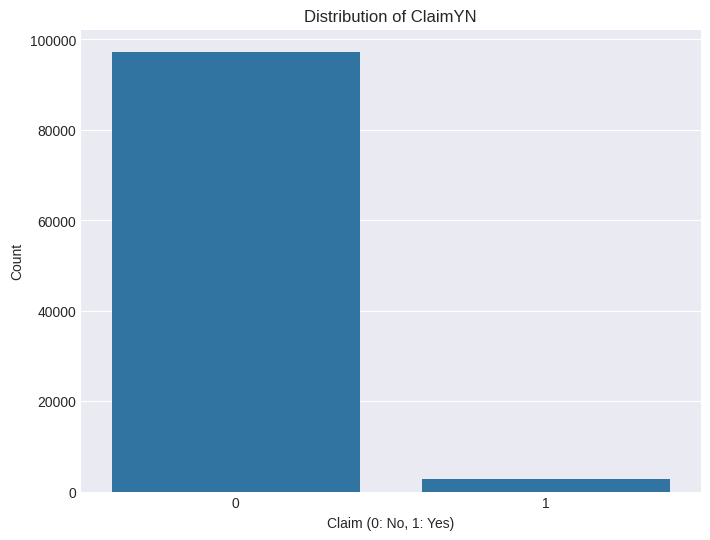

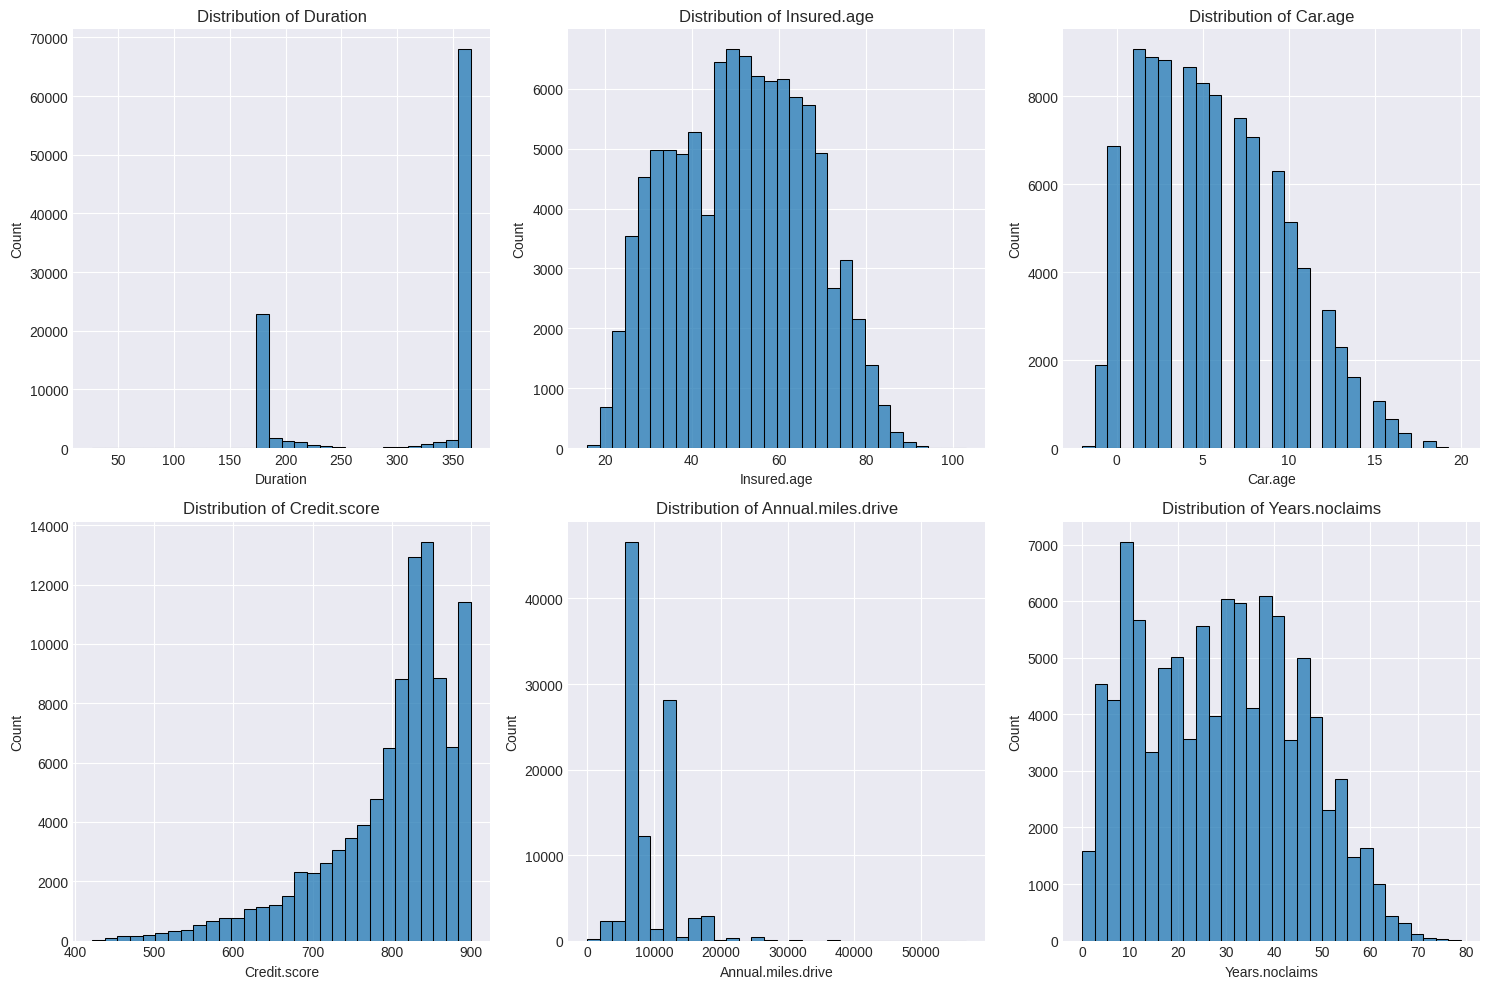

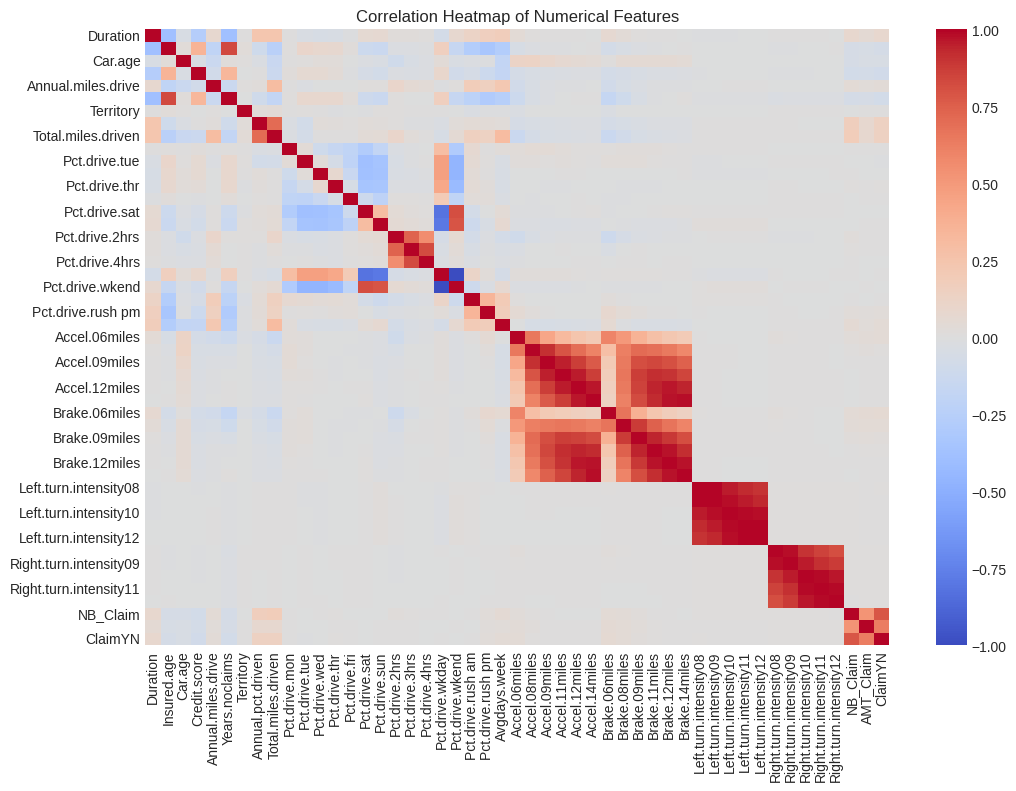

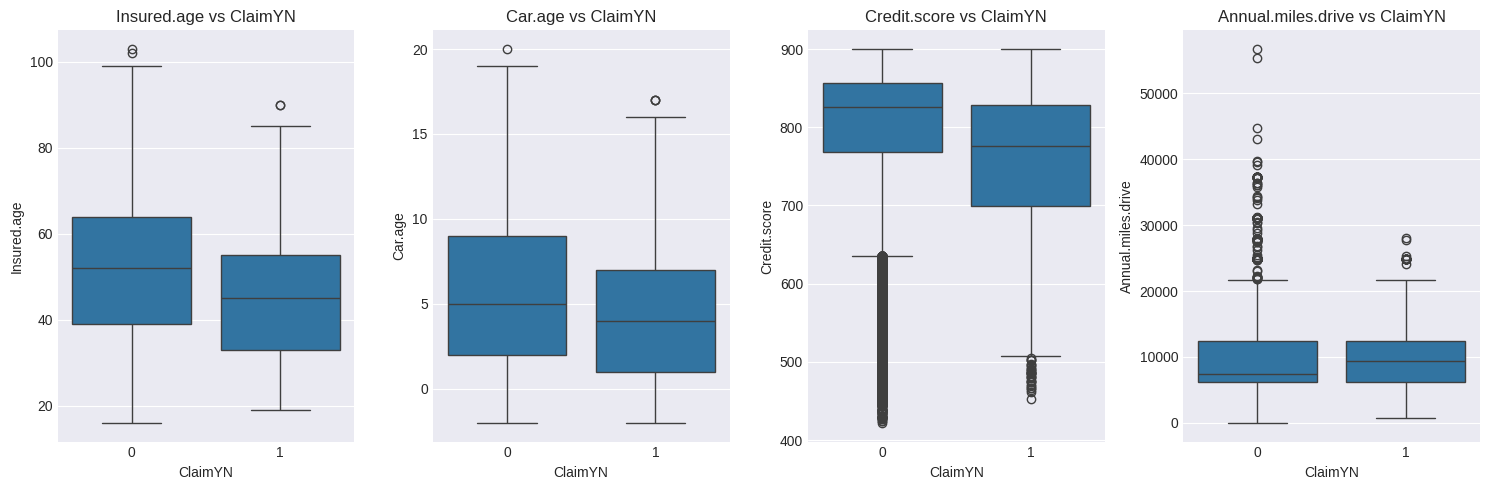

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import optuna
import shap
import lime.lime_tabular
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import tensorflow as tf

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

def load_and_eda(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Basic info
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create target variable
    df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

    # EDA Visualizations
    # 1. Class Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='ClaimYN', data=df)
    plt.title('Distribution of ClaimYN')
    plt.xlabel('Claim (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.show()

    # 2. Numerical Features Distribution
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols[:6], 1):  # Show first 6 for brevity
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=30)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # 4. Box Plots for Key Features vs ClaimYN
    key_features = ['Insured.age', 'Car.age', 'Credit.score', 'Annual.miles.drive']
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(key_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='ClaimYN', y=col, data=df)
        plt.title(f'{col} vs ClaimYN')
    plt.tight_layout()
    plt.show()

    return df

# Usage
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = load_and_eda(file_path)

# Step 2: Preprocessing



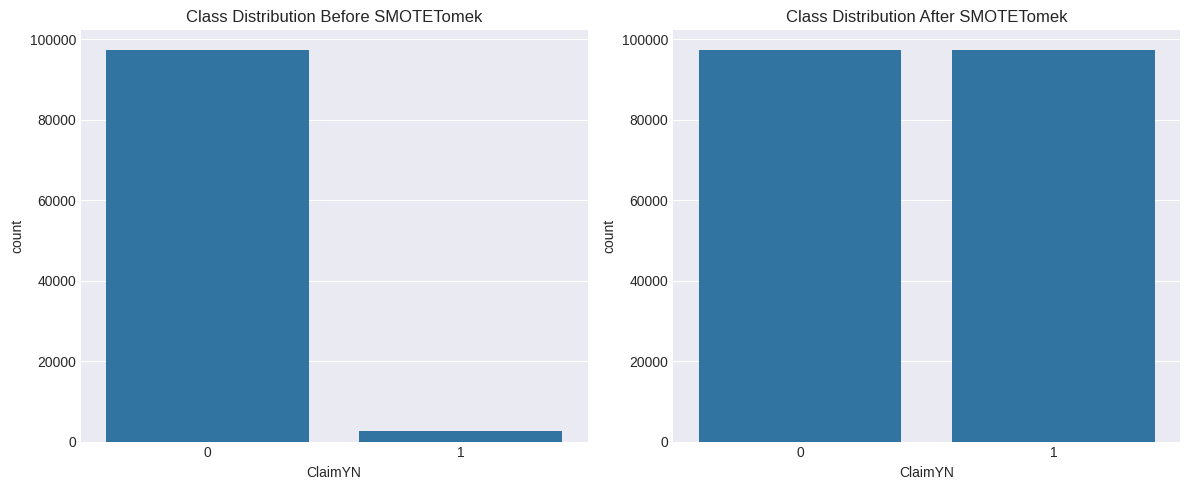

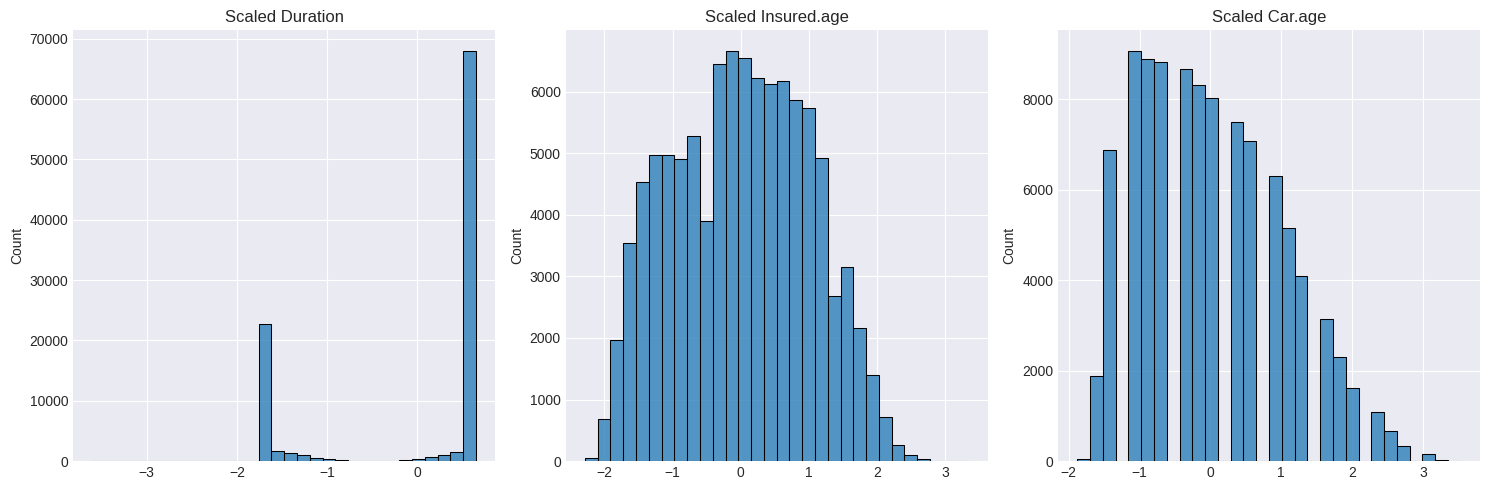

In [ ]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

    # Encode categorical variables
    df = pd.get_dummies(df, drop_first=True)

    # Separate features and target
    X = df.drop('ClaimYN', axis=1)
    y = df['ClaimYN']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Handle class imbalance
    smt = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smt.fit_resample(X_scaled, y)

    # Visualizations
    # 1. Class Distribution Before and After SMOTETomek
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['ClaimYN'])
    plt.title('Class Distribution Before SMOTETomek')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Class Distribution After SMOTETomek')
    plt.tight_layout()
    plt.show()

    # 2. Scaled Feature Distribution
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(X.columns[:3], 1):  # Show first 3 for brevity
        plt.subplot(1, 3, i)
        sns.histplot(X_scaled[:, X.columns.get_loc(col)], bins=30)
        plt.title(f'Scaled {col}')
    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled, X.columns.tolist()

# Usage
X, y, feature_names = preprocess_data(df)

# Step 3: Feature Engineering



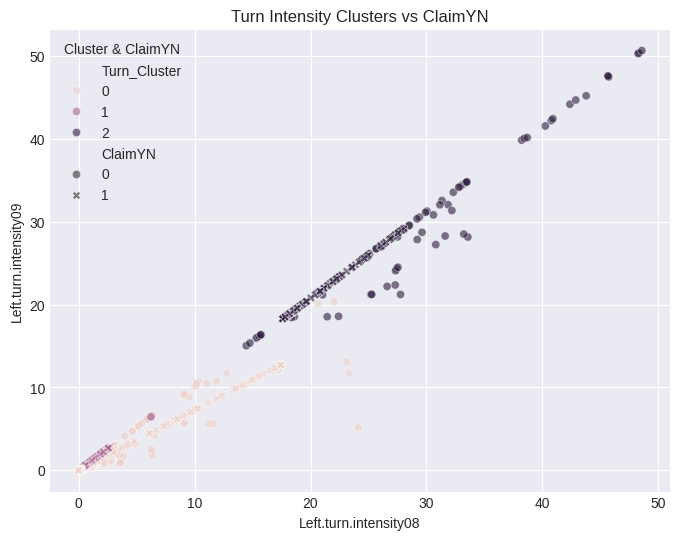

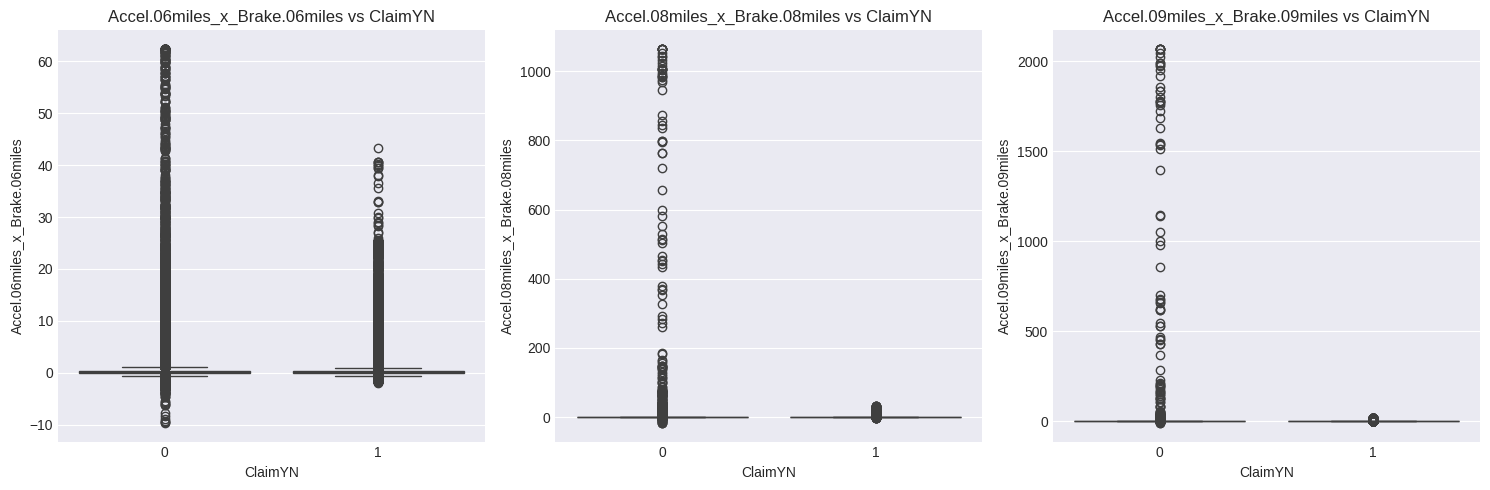

In [ ]:
def feature_engineering(X, feature_names, y):
    X_df = pd.DataFrame(X, columns=feature_names)

    # Interaction terms
    accel_cols = [col for col in feature_names if 'Accel' in col]
    brake_cols = [col for col in feature_names if 'Brake' in col]
    for accel, brake in zip(accel_cols, brake_cols):
        X_df[f'{accel}_x_{brake}'] = X_df[accel] * X_df[brake]

    # Cluster turn intensities
    turn_cols = [col for col in feature_names if 'turn.intensity' in col]
    if turn_cols:
        kmeans = KMeans(n_clusters=3, random_state=42)
        X_df['Turn_Cluster'] = kmeans.fit_predict(X_df[turn_cols])

        # Visualization: Cluster Scatter Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_df[turn_cols[0]], y=X_df[turn_cols[1]], hue=X_df['Turn_Cluster'], style=y, alpha=0.6)
        plt.title('Turn Intensity Clusters vs ClaimYN')
        plt.xlabel(turn_cols[0])
        plt.ylabel(turn_cols[1])
        plt.legend(title='Cluster & ClaimYN')
        plt.show()

    # Interaction Terms vs ClaimYN
    interaction_cols = [col for col in X_df.columns if '_x_' in col]
    if interaction_cols:
        plt.figure(figsize=(15, 5))
        for i, col in enumerate(interaction_cols[:3], 1):  # Show first 3
            plt.subplot(1, 3, i)
            sns.boxplot(x=y, y=X_df[col])
            plt.title(f'{col} vs ClaimYN')
        plt.tight_layout()
        plt.show()

    return X_df.values, X_df.columns.tolist()

# Usage
X, feature_names = feature_engineering(X, feature_names, y)

# Step 4: Feature Selection



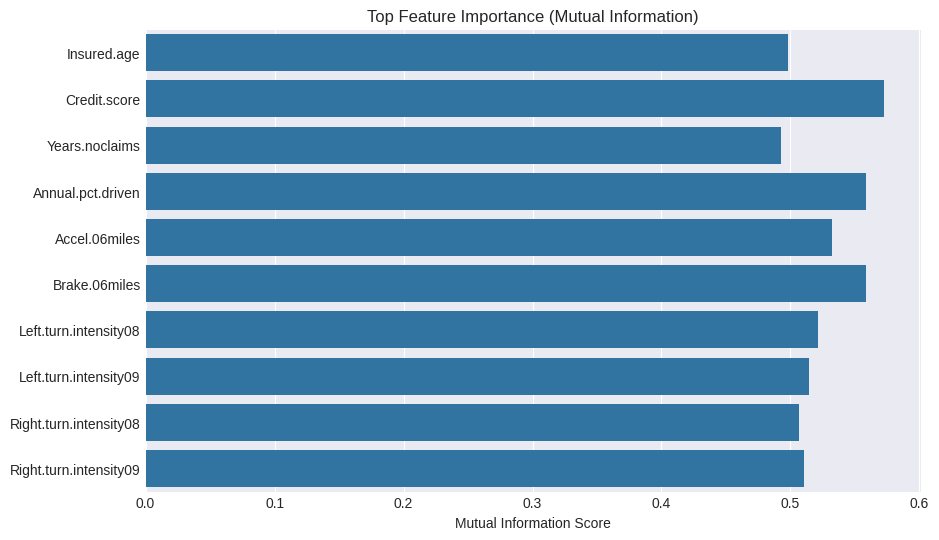

Top Features:
Credit.score: 0.5723
Brake.06miles: 0.5586
Annual.pct.driven: 0.5583
Accel.06miles: 0.5323
Left.turn.intensity08: 0.5211
Left.turn.intensity09: 0.5145
Right.turn.intensity09: 0.5105
Right.turn.intensity08: 0.5064
Insured.age: 0.4980
Years.noclaims: 0.4927


In [ ]:
def feature_selection(X_train, y_train, feature_names, top_k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    scores = selector.scores_

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores[selected_indices], y=selected_features)
    plt.title('Top Feature Importance (Mutual Information)')
    plt.xlabel('Mutual Information Score')
    plt.show()

    print("Top Features:")
    for feature, score in sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features, selector.transform(X_train), selector.transform(X_test)

# Split data before feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selected_features, X_train_selected, X_test_selected = feature_selection(X_train, y_train, feature_names)

# Step 5: Variational Autoencoder (VAE)



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class Sampling(Layer):
    """Custom Keras layer for sampling from a normal distribution."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    """Custom VAE model to handle loss computation."""
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * data.shape[1]  # Scale by input dimension
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def create_vae(X_train, X_test, latent_dim=32):
    """
    Create and train a Variational Autoencoder.

    Parameters:
    - X_train: Training data (NumPy array)
    - X_test: Test data (NumPy array)
    - latent_dim: Dimension of the latent space

    Returns:
    - X_train_ae: Encoded training features
    - X_test_ae: Encoded test features
    """
    # Normalize inputs to [0, 1] for binary cross-entropy
    X_train_norm = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test_norm = (X_test - X_test.min()) / (X_test.max() - X_test.min())

    # Input dimension
    input_dim = X_train.shape[1]

    # Encoder
    inputs = Input(shape=(input_dim,))
    h = Dense(64, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(64, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(decoder_h)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam')

    # Train
    vae.fit(X_train_norm, epochs=50, batch_size=32, verbose=0)

    # Get latent features
    X_train_ae = encoder.predict(X_train_norm, verbose=0)[2]  # Get z
    X_test_ae = encoder.predict(X_test_norm, verbose=0)[2]    # Get z

    # Visualization: Latent Space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_train_ae[:, 0], y=X_train_ae[:, 1], hue=y_train, alpha=0.6)
    plt.title('VAE Latent Space vs ClaimYN')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(title='ClaimYN')
    plt.show()

    return X_train_ae, X_test_ae

# Step 6: Model Training with Bayesian Optimization



In [ ]:
def train_models(X_train, y_train):
    def objective(trial):
        gb_params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 7)
        }
        gb = GradientBoostingClassifier(**gb_params, random_state=42)

        nn_params = {
            'hidden_layer_sizes': trial.suggest_categorical('nn_hidden_layers', [(50,50), (100,50), (100,100)]),
            'alpha': trial.suggest_float('nn_alpha', 1e-5, 1e-2, log=True)
        }
        nn = MLPClassifier(**nn_params, max_iter=1000, random_state=42)

        lgb_params = {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 50)
        }
        lgb = LGBMClassifier(**lgb_params, random_state=42)

        estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
        stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

        scores = cross_val_score(stack, X_train, y_train, cv=5, scoring='roc_auc')
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Visualization: Optimization History
    plt.figure(figsize=(8, 6))
    optuna.visualization.plot_optimization_history(study)
    plt.title('Hyperparameter Optimization History')
    plt.show()

    # Train final models
    best_params = study.best_params
    gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    nn = MLPClassifier(
        hidden_layer_sizes=best_params['nn_hidden_layers'],
        alpha=best_params['nn_alpha'],
        max_iter=1000,
        random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=best_params['lgb_n_estimators'],
        learning_rate=best_params['lgb_learning_rate'],
        num_leaves=best_params['lgb_num_leaves'],
        random_state=42
    )

    estimators = [('gb', gb), ('nn', nn), ('lgb', lgb)]
    stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

    for name, model in estimators:
        model.fit(X_train, y_train)
    stack.fit(X_train, y_train)

    return {'gb': gb, 'nn': nn, 'lgb': lgb, 'stack': stack}



# Step 7: Model Evaluation



In [ ]:
def evaluate_models(models, X_test, y_test):
    results = {}
    plt.figure(figsize=(15, 10))

    # ROC Curves
    plt.subplot(2, 2, 1)
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
        y_pred = model.predict(X_test)

        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'mcc': matthews_corrcoef(y_test, y_pred),
            'auc_roc': auc
        }

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()

    # Confusion Matrices
    for i, (name, model) in enumerate(models.items(), 2):
        plt.subplot(2, 2, i)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    # Metrics Comparison
    metrics_df = pd.DataFrame(results).T
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar')
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results



# Step 8: Interpretability



In [ ]:
def interpret_models(models, X_train, X_test, feature_names, sample_idx=0):
    explainer = shap.KernelExplainer(
        models['stack'].predict_proba, shap.sample(X_train, 100)
    )
    shap_values = explainer.shap_values(X_test[sample_idx:sample_idx+1])

    # SHAP Summary Plot
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance')
    plt.show()

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train, feature_names=feature_names, class_names=['No Claim', 'Claim'], mode='classification'
    )
    lime_exp = lime_explainer.explain_instance(X_test[sample_idx], models['stack'].predict_proba)

    # LIME Plot
    lime_exp.show_in_notebook(show_table=True, show_all=False)

    return shap_values, lime_exp


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.dri

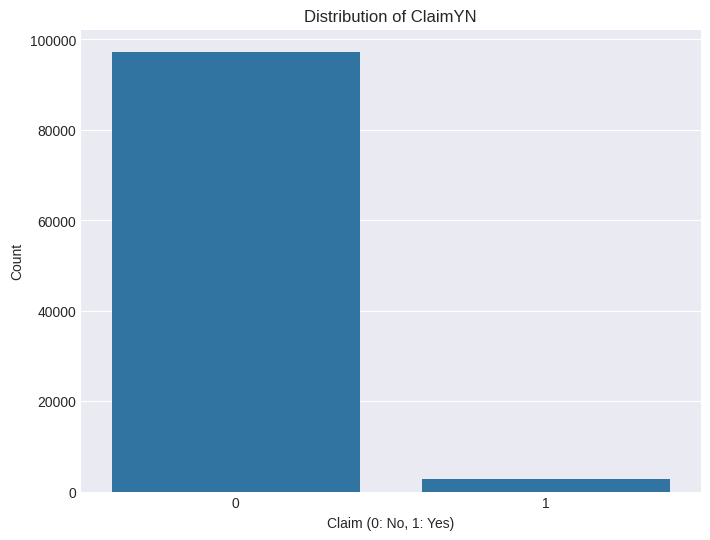

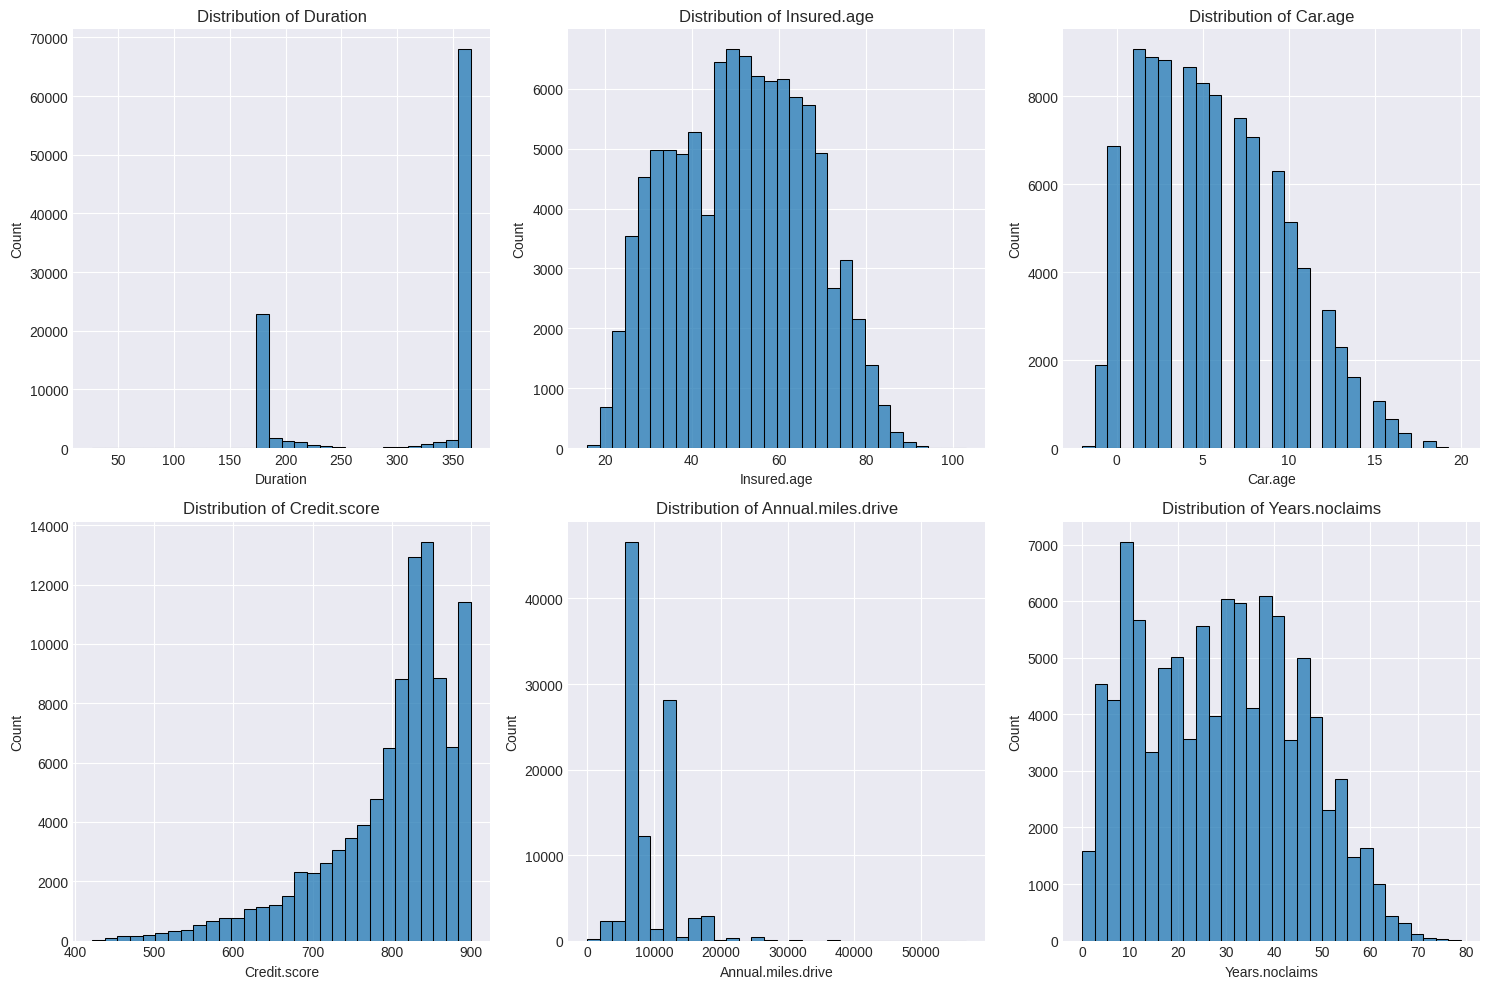

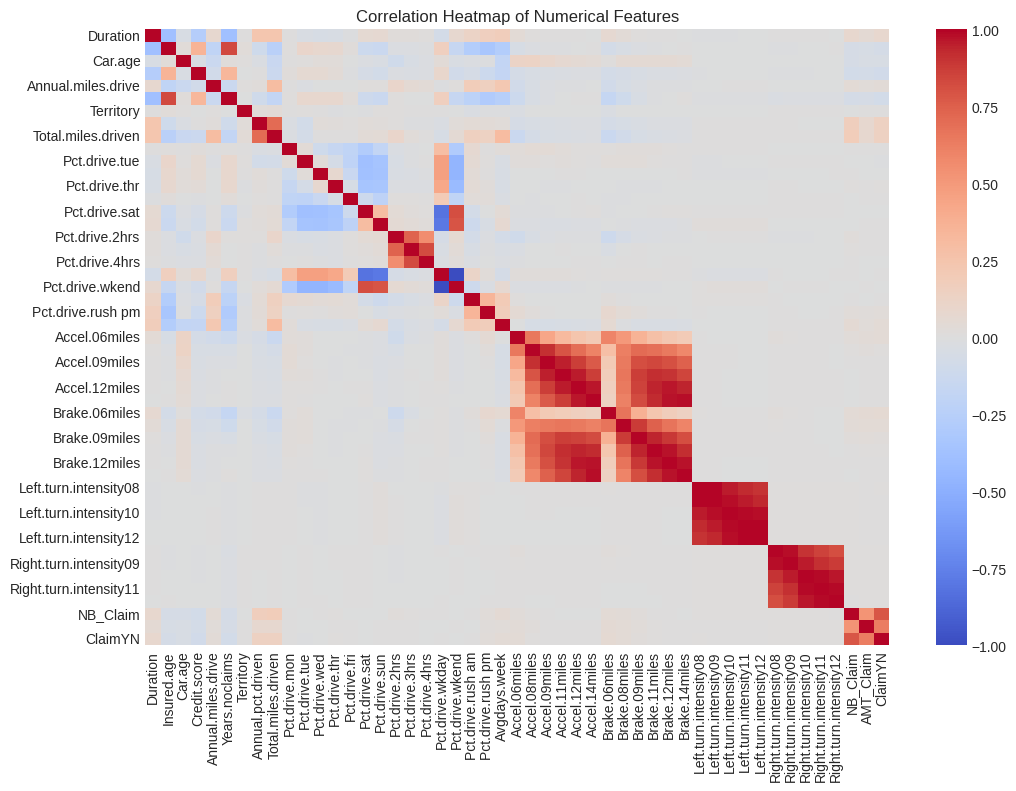

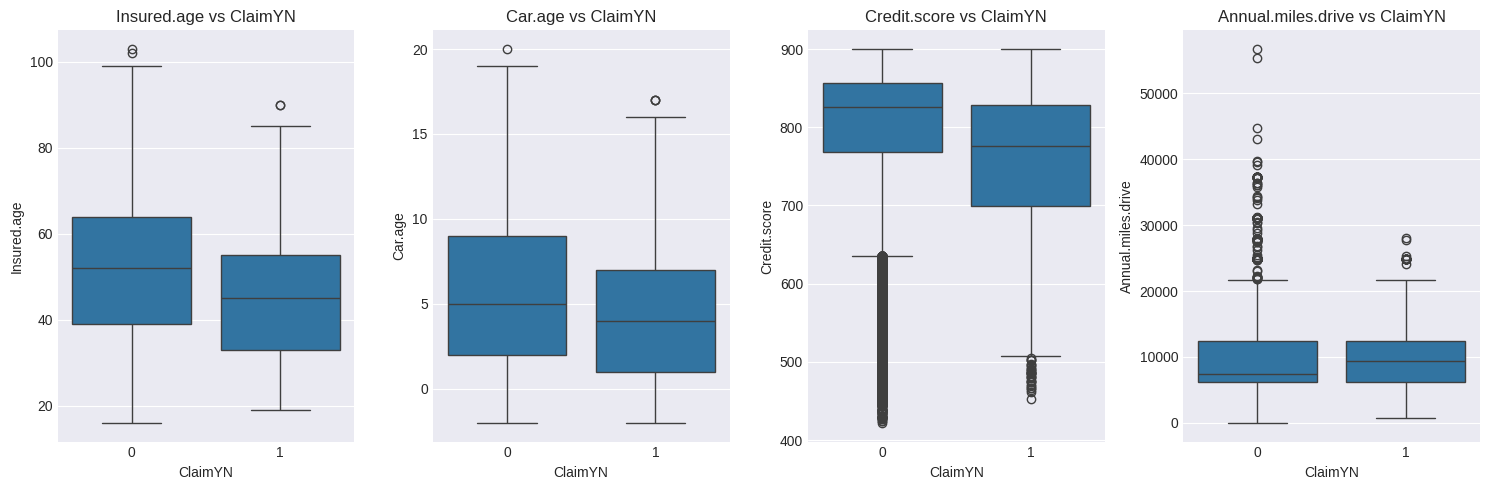

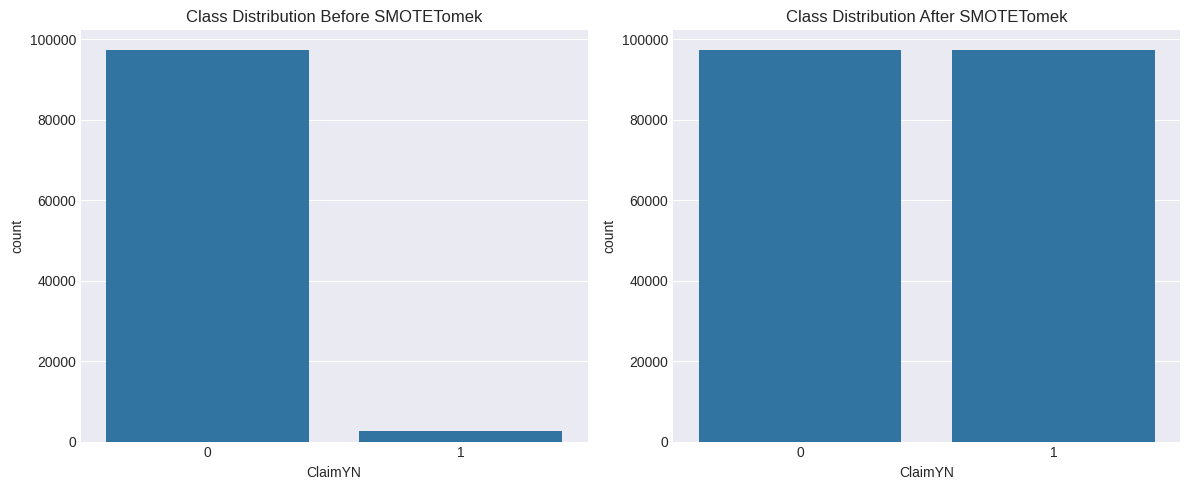

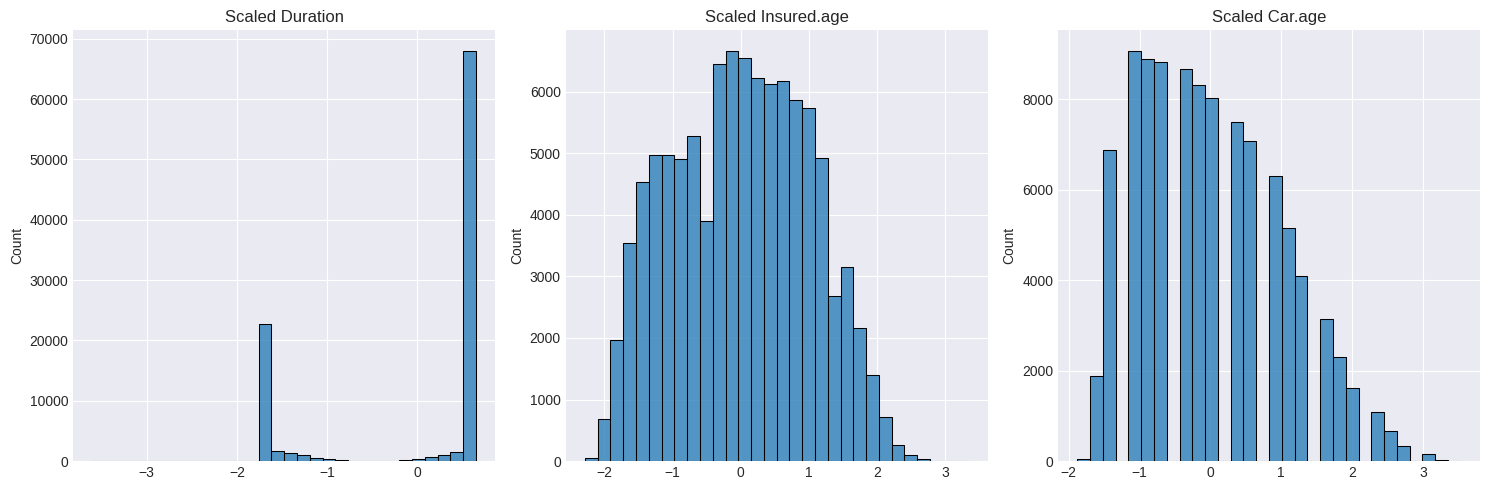

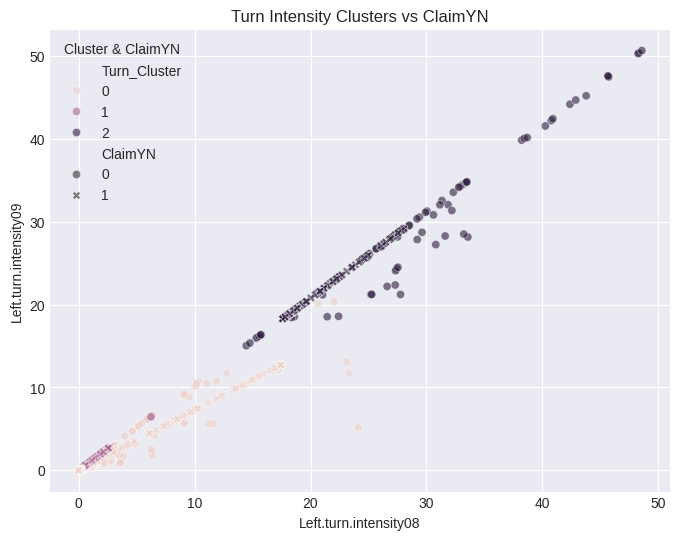

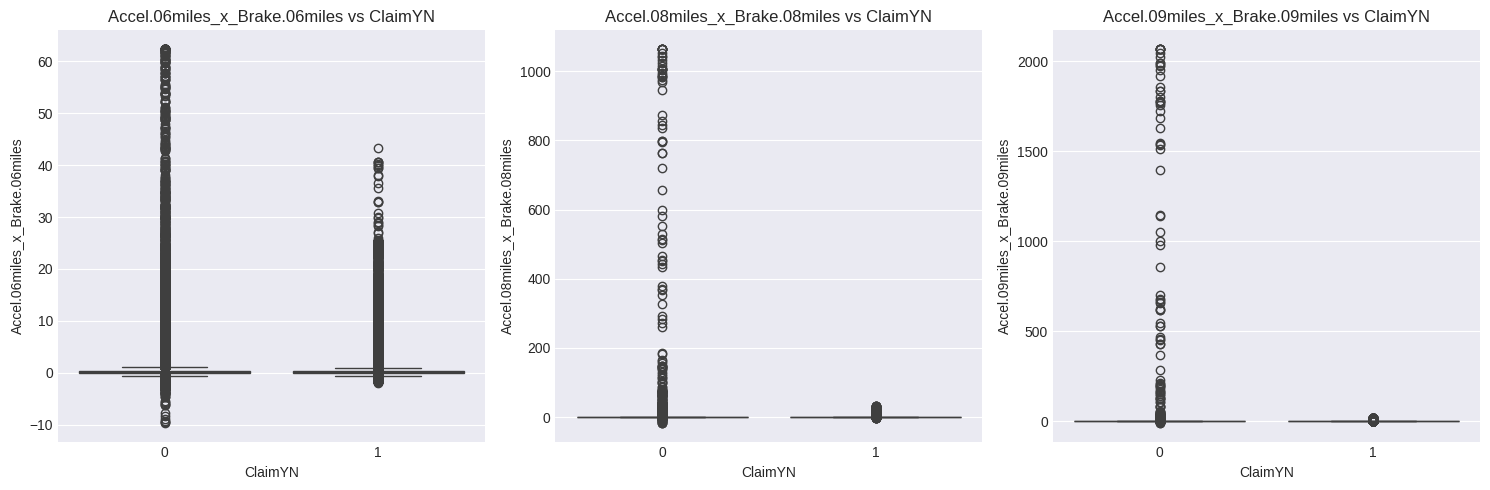

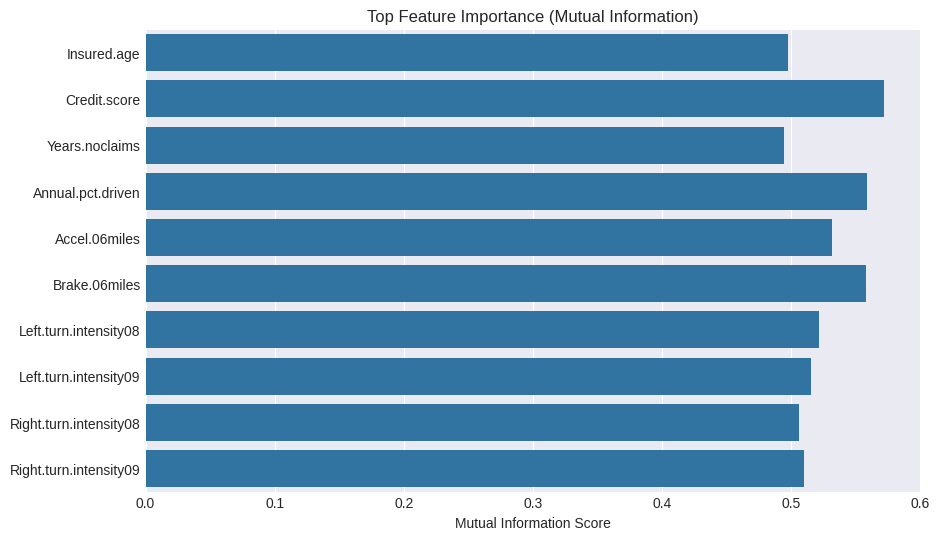

Top Features:
Credit.score: 0.5717
Annual.pct.driven: 0.5585
Brake.06miles: 0.5579
Accel.06miles: 0.5319
Left.turn.intensity08: 0.5212
Left.turn.intensity09: 0.5151
Right.turn.intensity09: 0.5098
Right.turn.intensity08: 0.5063
Insured.age: 0.4976
Years.noclaims: 0.4943


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Combine all steps
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'

# Step 1: EDA
df = load_and_eda(file_path)

# Step 2: Preprocessing
X, y, feature_names = preprocess_data(df)

# Step 3: Feature Engineering
X, feature_names = feature_engineering(X, feature_names, y)

# Step 4: Split Data and Feature Selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
selected_features, X_train_selected, X_test_selected = feature_selection(X_train, y_train, feature_names)

# Step 5: Variational Autoencoder
X_train_ae, X_test_ae = create_vae(X_train_selected, X_test_selected)

# Step 6: Train Models
models = train_models(X_train_ae, y_train)

# Step 7: Evaluate Models
results = evaluate_models(models, X_test_ae, y_test)

# Step 8: Interpret Models
shap_values, lime_exp = interpret_models(models, X_train_ae, X_test_ae, selected_features)